The recent advent of DeepMind's Alpha Zero has been a huge advancement for AI, showing how to bypass training data provided by humans entirely and achieve superhuman status in a variety of deterministic, perfect-information games. (If you're not familiar with how Alpha Zero works, [here's a good article explaining](http://tim.hibal.org/blog/alpha-zero-how-and-why-it-works/).)

In the world of chess however, computers have been beating the top human players for over two decades, so while this advancement is certainly interesting, it's not necessarily a game changer for human chess players. 

What I'd like to explore in this post is building a new type of chess engine: Not a chess engine focused on beating any opponent, but a chess engine focused on being useful to human players. 

Note: this post will use [Standard Algebraic Notation (SAN)](https://en.wikipedia.org/wiki/Algebraic_notation_(chess)) to describe chess moves and [Forsyth-Edwards Notation (FEN)](https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation) to describe board positions.

# What's Wrong With Stockfish?
[Stockfish](https://en.wikipedia.org/wiki/Stockfish_(chess)) is currently among the top chess engines in strength, but as many have pointed out, [chess engines are not your friend](https://www.chess.com/article/view/chess-engines-are-not-your-friend) if you're not at a master level. Stockfish will recommend the strongest moves *for Stockfish, playing against Stockfish*, not the strongest move for a player of your skill level, which can be a big problem when you're not even close to Stockfish in playing strength. If you use Stockfish to analyze different positions to help in your future games, you could easily be lead astray with ideas that are too complicated for a player of your skill level to pull off. 

For example, let's say it's your move and there's a highly complicated 10 move combination that starts off with a queen sacrifice. If you play perfectly, you have a guaranteed win, but if you miss just a single move, you no longer have a forced checkmate and you're down a queen. Alternatively, let's say you have a much simpler move that wins a minor piece right away. Which move should you make? Unless you're a grand master and can correctly see the whole 10 move combination, you should probably just take the piece. According to Stockfish however, this would be a huge mistake, as you're foregoing a forced checkmate sequence!

Besides entering overly complicated lines, Stockfish also fails at what I will call meta strategy. For example, let's say you are in a losing position, and you have an opportunity to play a move that complicates the position greatly, giving your opponent a chance to make a mistake, but it also gives them a chance to win more quickly with correct play. Alternatively, you could play a move that simplifies the position and helps you slightly, but still keeps you in a losing position. Stockfish will recommend the later, but this almost guarantees that you will just slowly lose the game. For human play, the first move is clearly better, since the chances of your opponent making a mistake are not zero.

# A Better Chess Engine
A better chess engine that would be useful to human play will need to take human fallibility into account. With this in mind, let's look at some concrete examples where defying the engine's recommendation can lead to success. The Englund Gambit provides a basic example that applies to lower-skilled players, and the play of Mikhail Tal gives the higher-skilled analogue.

## The Englund Gambit
The Englund Gambit main line starts: 
1. d4 e5 
2. dxe5 Nc6 
3. Nf3 Qe7 
4. Bf4 Qb4+

giving this position:

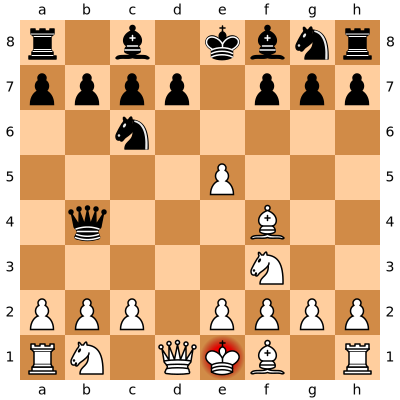

In [1]:
import chess

fen = 'r1b1kbnr/pppp1ppp/2n5/4P3/1q3B2/5N2/PPP1PPPP/RN1QKB1R w KQkq - 5 5'
board = chess.Board(fen)
board

We choose the Englund Gambit for its desirable properties that show how chess engines think vs how humans think, and how engines like Stockfish aren't always helpful, and are sometimes hurtful, for weaker human players.

### The Englund Gambit is "bad" for black
The Englund Gambit is almost never used among top players and Stockfish would never play it because a good refutation exists.

However, among weaker players, the Englund Gambit does very well. For example, from my own Chess.com archive, I have reached the above position as black 42 times with results of 67% win, and 33% loss (against opponents of an average skill the same as mine, around 1700 Elo on chess.com, in rapid or blitz games).

Stockfish evaluates this position as +2 for white (i.e. white is winning by roughly 2 pawns), but clearly based on my stats above, this position pragmatically favors black if the players are of low enough skill.

So why is this?

### The Englund Gambit requires precise play by white
If white plays all the correct moves, he will be able to realize that Stockfish +2 evaluation, probably a lot more. Playing all the correct moves is trivial for an engine or a grandmaster, but it is clearly much harder for weaker players.

Intuitively the Englund Gambit only needs a single misstep from white to lose the game, and it gives white many opportunities to make this mistake. 

### The Englund Gambit challenges human intuition
In many of the Englund Gambit continuations, the intuitive and seemingly clever moves lead to disaster. One of the best responses requires a temporary piece sacrifice that many weaker players wouldn't even look at. If it's a blitz game, or the player gets a little lazy and doesn't fully evaluate the position, they can easily fall into traps with natural looking moves. An engine is never lazy and doesn't have a concept for a "natural" move, so the engine won't blunder or play seemingly elegant and clever moves (that are actually bad). Good for the engine, but this doesn't help a player that gets blindsided by a sharp minefield like the Englund over the board.

## The Variations
Below are the variations seen from my 42 games with this starting position. I terminate the leaf nodes and use a Stockfish evaluation when there are no more tactical complications, so we can assume that the evaluation is accurate. I then roll up the leaf evaluations proportional to how frequently the line is played, arriving at an estimated expected evaluation for each node.

# SECTION SPLIT

## Mikhail Tal
[Mikhail Tal](https://en.wikipedia.org/wiki/Mikhail_Tal) was a Grandmaster and World Chess Champion known for his daring and creative [playing style](https://en.wikipedia.org/wiki/Mikhail_Tal#Playing_style). Rather than always choosing the strongest theoretical move, he would often sacrifice pieces in order to gain the initiative and strong attacks. Many of his game winning moves were refuted in post-game analysis, yet during the game they were strong enough to win. 

For example, in his famous game 6 of the world championship match against Botvinnik, Tal, playing with the black pieces, had this position with black to move.

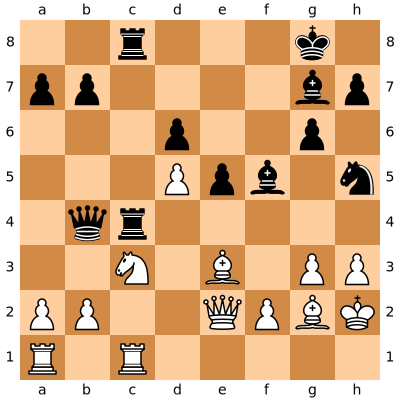

In [2]:
fen = '2r3k1/pp4bp/3p2p1/3Ppb1n/1qr5/2N1B1PP/PP2QPBK/R1R5 b - - 0 1'
board = chess.Board(fen)
board

Stockfish evaluates this position as roughly equal and suggests that black retreats his knight to f6. Instead, Tal played his knight forward to f4, allowing it to be captured by the pawn. After this move, Stockfish evaluates that Botvinnik is winning by over 2 pawns, yet Tal created such a complicated and hard-to-play position that Botvinnik quickly fell apart. 

This game is just one of many where Tal played a move that Stockfish would consider a mistake and went on to win the game. So are these moves really mistakes? 

## The Goal
By now it should be clear what a "better" chess engine could accomplish. We want an engine that can take the players' skill (adjusted for time formats) as inputs, and then intelligently recommend moves for that player or evaluate the position taking human error into account. The engine's goal would be to align with actual observed results, rather than the theoretical moves and evaluations. 

## How it works
We will borrow some ideas from [AlphaZero](https://arxiv.org/pdf/1712.01815.pdf), e.g. we will use a deep convolutional neural network to get the policy, and we will use [Monte Carlo tree search (MCTS)](https://en.wikipedia.org/wiki/Monte_Carlo_tree_search) rollouts. However, the goals of this engine are to predict the move a human would make, not to find the strongest move, so our model will be fundamentally different than AlphaZero.

### The Problem Definition
For any given board state $s$ and rating $r$ of the player to move, we want to estimate a probability distribution over the legal moves that predicts which move the human player would make. That is, we want to find $P(a|s, r)$ where $a$ is each legal action.

Using this information, we can then roll out positions for evaluation and explore which lines should be taken, i.e. which moves are the best taking into account human error.

### Step 1: Intuition
Get the policy from the neural network. Mask out illegal moves and reweight to get a probability distribution over legal moves.

$\vec{p} = f_\theta(s, r)$ 

where $f$ is the neural network and $\theta$ represents the networks weights.

If our policy was good enough, this would be all we need, but training a network to be that accurate is infeasible. Think of this output as a human's intuition. Some moves will jump out as good candidate moves immediately, and some can be safely ignored. This intuition will help guide the allocation of future brain/computing power, but subsequent moves still must be calculated to make sure that they're tactically sound.

### Step 2: Calculation
This step requires searching through the game tree and adjusting the policy (prior) probability based on how strong each move is. As discussed above, the "strength" of a move is subjective, so there are a variety of ways that this step could be implemented. E.g. a value neural network combined with traditional MCTS as used in AlphaZero could estimate move strength. However, since we don't have 5,000 [TPUs](https://en.wikipedia.org/wiki/Tensor_processing_unit) at our disposal like Google DeepMind, we will have to "cheat" and use Stockfish's evaluation capabilities.

Concretely, we will learn the function:

$\vec{\pi} = g_\tau(\vec{p}, \vec{v}, r)$

where $g$ is a basic multilayer perceptron network, $\tau$ is the network weights, $\vec{v}$ are the evaluations for the legal moves provided by Stockfish at various depths, and $r$ is still the player rating. Thus the tree search occurs within the Stockfish evaluation, which uses [alpha-beta search](https://en.wikipedia.org/wiki/Alpha%E2%80%93beta_pruning).

The basic idea here is that stronger players should be more likely to play stronger moves, while weaker players will have a more even probability distribution, increasing their chances of making a blunder. Weaker players may more closely follow lower depth evaluations (as their calculation ability is weaker), while stronger players may follow deeper evaluations.

Note that using Stockfish in an attempt to overcome the shortcomings of Stockfish does create a bit of a bootstrapping problem. However, the Stockfish evaluations are not biased in either direction and will converge to our ideal evaluations at quiescent nodes (nodes where all the tactics have played out), so after the rollouts done in the next step this does not appear to be a big issue.

### Step 3: Evaluation
Use MCTS to expand the search tree. Randomly select which node to expand by the probability distribution obtained from the previous step. In this way, lines that are more likely to be played will be expanded further and will have a more accurate evaluation. 

Leaf node valuations are then rolled up weighted by their probabilities. This gives the expectation of the evaluation of each branch, rather than the minimax best as obtained by Stockfish. Using the expectation will more accurately evaluate the position for human play as the chance for errors is present. 

### Step 4: Analysis
This engine could perform many different types of analysis. For example, common openings could be evaluated through this lens to find what works best for a given skill level. Furthermore, specific variations could be prepared for tournament players that are hard to play for your opponent, but manageable for you.

## Results
So does it work? 

### Englund Gambit for Elo of 1500
First, we'll look at the same Englund Gambit starting position for lower skilled players (elo of 1500). To make the situation comparable to the actual data with my games, where I have some moves memorized, some rollouts are deterministically chosen for black. For example, after Bd2, I always play Qxb2, so this move is deterministically chosen for evaluation.

# SECTION SPLIT

These initial results are quite good. The evaluation indicates that for weaker players, black is overall better in this position (assuming black knows the main lines), which agrees with the data from my own games. 

The only obvious flaw in the evaluation is that the initial move Nc3 for white has a much higher estimated probability of being played than the actual observed frequency. If you truly understand this position, it makes sense why this move is estimated with such a high probability. I suspect that this is a very difficult move for the engine to predict accurately for a couple of reasons. Nc3 is a very natural move that is frequently played at some point in the opening, and is usually a good option to block a check on the diagonal, so the first policy network would favor it. The second network would lower the probability if it was a bad move, but it is a deceivingly good move, leading to a good combination. It's not played frequently in my games I suspect because of slight tunnel vision. The player sees the bishop is being attacked and that they can drop it back to block the check and protect it. They don't even look at Nc3. For the engine to pick up on this type of human behavior, I suspect the policy network would have to be much deeper and would require more training data.

Overall, these results are encouraging, and they are certainly an improvement upon the Stockfish evaluation.

### Englund Gambit for Elo of 3000
Now we'll look at the same position for very strong players. As discussed previously, the Englund Gambit is rarely ever used among top players, because a highly skilled player wouldn't fall into the same traps like a low skilled player. So, we would expect the evaluation to be better for white. There isn't much raw data to support us here, but from the chess.com database, this position was reached 9 times among master games with white winning 5, 1 draw, and black winning 3. 

# SECTION SPLIT

Again, we see that the overall evaluation agrees that white is better here.

## Exploring Openings
Next, we looked at all chess opening moves that are given an [ECO Code](https://en.wikipedia.org/wiki/List_of_chess_openings). The positions from the openings have been run through our engine, each for an Elo of 1500 (very weak, compared to masters). Here we can see some openings that diverge the most from their Stockfish evaluations.

As expected, the positions with the largest difference between the Stockfish evaluation and our evaluation are sharp positions, including many gambits. (A gambit in chess is when you give up material for another advantage, such as a strong attack). These positions provide many opportunities for a weaker player to make mistakes.

(Note that evaluations are in terms of -1 to +1, with -1 being completely winning for black, +1 being completely winning for white, and 0 being an equal position. Stockfish usually evaluates using pawns or centipawns as the unit.)

,Eco,Name,fen,Moves,Stockfish Eval,Our Eval
1883,C37,"King's Gambit Accepted, Double Muzio Gambit, Young Gambit",rnb2bnr/pppp1k1p/5q2/8/4P3/2N1pQ2/PPP3PP/R4RK1 w -,1. e4 e5 2. f4 exf4 3. Nf3 g5 4. Bc4 g4 5. O-O gxf3 6. Qxf3 Qf6 7. Bxf7+ Kxf7 8. d4 Qxd4+ 9. Be3 Qf6 10. Nc3 fxe3,0.969745,-0.284953
2125,C44,"Scotch, Cochrane Variation",r1bqkb1r/pp1p1Npp/2p1nn2/8/2B1P3/8/PPP2PPP/RNBQ1RK1 b kq,1. e4 e5 2. Nf3 Nc6 3. d4 Nxd4 4. Nxe5 Ne6 5. Bc4 c6 6. O-O Nf6 7. Nxf7,-0.201216,0.830207
2388,C60,"Ruy Lopez: Spanish Countergambit, Harding Gambit",r1b1kbnr/ppp2ppp/2N5/1B1p2q1/4P3/8/PPPP1PPP/RNBQK2R b KQkq,1. e4 e5 2. Nf3 Nc6 3. Bb5 d5 4. Nxe5 Qg5 5. Nxc6,-0.206966,0.725584
2359,C58,"Italian Game: Two Knights Defense, Blackburne Variation",r1bqkb1r/p4ppp/5n2/np2p1N1/8/5Q2/PPPP1PPP/RNB1K2R w KQkq,1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. Ng5 d5 5. exd5 Na5 6. Bb5+ c6 7. dxc6 bxc6 8. Qf3 cxb5,0.212702,-0.631178
1785,C30,"King's Gambit Declined: Norwalde Variation, Buecker Gambit",rnb1k1nr/pppp1ppp/8/4p3/1bB1Pq2/2N2N2/PPPP2PP/R1BQK2R b KQkq,1. e4 e5 2. f4 Qf6 3. Nc3 Qxf4 4. Nf3 Bb4 5. Bc4,0.543423,-0.272510
2132,C45,Scotch Game: Berger Variation,N1bk3r/pp1p1ppp/2n2n2/8/1b6/P4B1q/1PPN1P1P/R1BQK2R b KQ,1. e4 e5 2. Nf3 Nc6 3. d4 exd4 4. Nxd4 Qh4 5. Nb5 Bb4+ 6. Nd2 Qxe4+ 7. Be2 Qxg2 8. Bf3 Qh3 9. Nxc7+ Kd8 10. Nxa8 Nf6 11. a3,-0.710404,0.029961
2244,C51,"Italian Game: Evans Gambit, Fraser-Mortimer Attack",r2q1knr/pppb1Bpp/1b1p4/n7/3PP3/2N2N2/P1Q2PPP/R1B2RK1 b -,1. e4 e5 2. Nf3 Nc6 3. Bc4 Bc5 4. b4 Bxb4 5. c3 Bc5 6. d4 exd4 7. O-O d6 8. cxd4 Bb6 9. Nc3 Bg4 10. Qa4 Bd7 11. Qb3 Na5 12. Bxf7+ Kf8 13. Qc2,-0.613179,0.114570
1638,C21,Center Game: Kieseritzky Variation,rnbqkbnr/p2p1ppp/8/1pp5/2BpP3/5N2/PPP2PPP/RNBQK2R w KQkq,1. e4 e5 2. d4 exd4 3. Nf3 c5 4. Bc4 b5,0.384219,-0.270762
2937,D44,Semi-Slav Defense: Botvinnik System,rnbqkb1r/p4p2/2p1pn1p/1p2P1N1/2pP3B/2N5/PP3PPP/R2QKB1R b KQkq,1. d4 d5 2. c4 c6 3. Nf3 Nf6 4. Nc3 e6 5. Bg5 dxc4 6. e4 b5 7. e5 h6 8. Bh4 g5 9. Nxg5,-0.047963,0.591256
2011,C41,"Philidor Defense: Lion Variation, Bishop Sacrifice",r1bqk2r/pppnbBpp/3p1n2/4p3/3PP3/2N2N2/PPP2PPP/R1BQK2R b KQkq,1. e4 e5 2. Nf3 d6 3. d4 Nf6 4. Nc3 Nbd7 5. Bc4 Be7 6. Bxf7+,-0.315823,0.262523


King's Gambit Accepted, Double Muzio Gambit, Young Gambit
Stockfish Eval: 0.97
Our Eval: -0.285


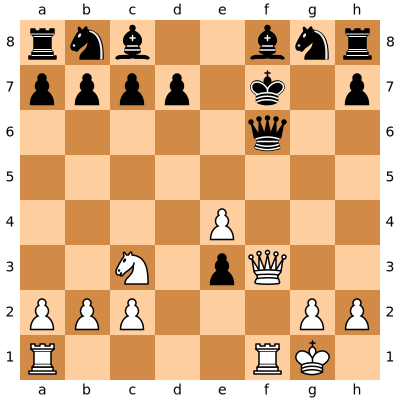

Scotch, Cochrane Variation
Stockfish Eval: -0.201
Our Eval: 0.83


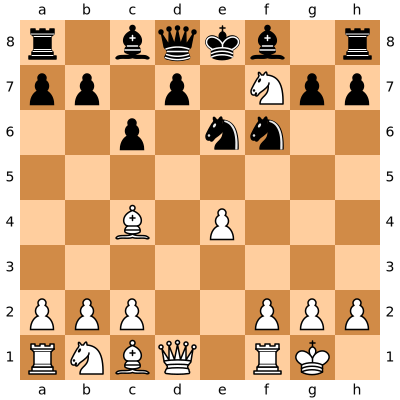

Ruy Lopez: Spanish Countergambit, Harding Gambit
Stockfish Eval: -0.207
Our Eval: 0.726


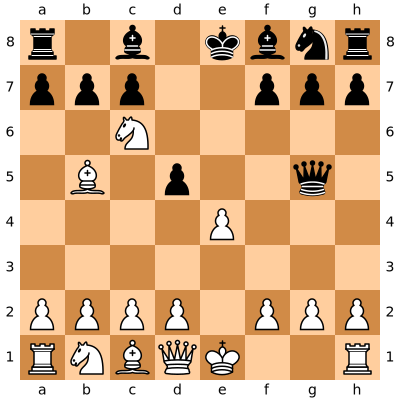

Italian Game: Two Knights Defense, Blackburne Variation
Stockfish Eval: 0.213
Our Eval: -0.631


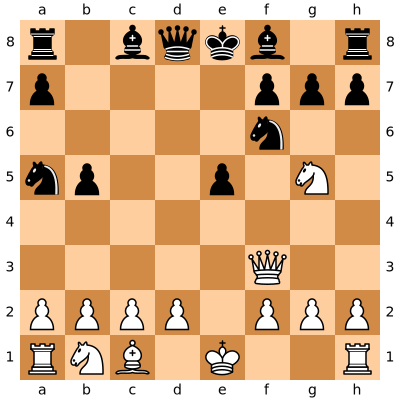

King's Gambit Declined: Norwalde Variation, Buecker Gambit
Stockfish Eval: 0.543
Our Eval: -0.273


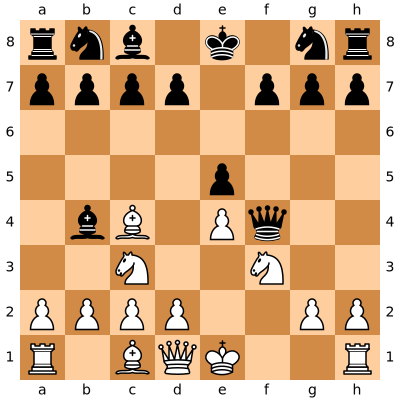

Scotch Game: Berger Variation
Stockfish Eval: -0.71
Our Eval: 0.03


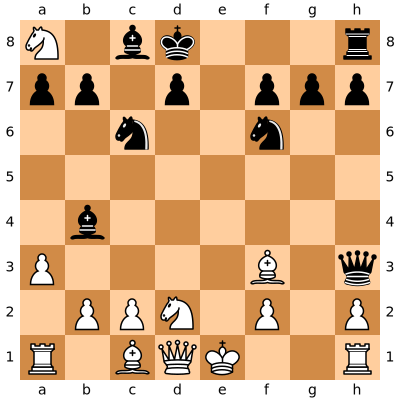

Italian Game: Evans Gambit, Fraser-Mortimer Attack
Stockfish Eval: -0.613
Our Eval: 0.115


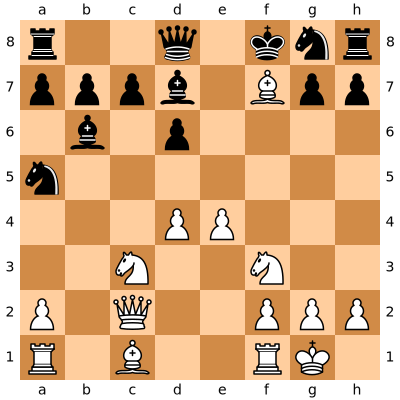

Center Game: Kieseritzky Variation
Stockfish Eval: 0.384
Our Eval: -0.271


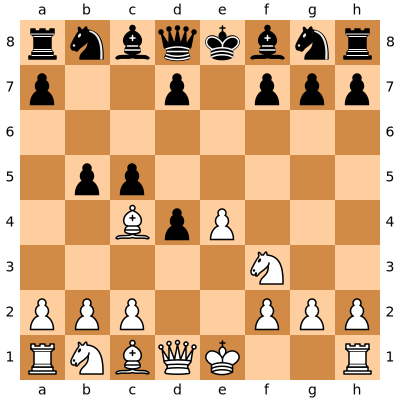

Semi-Slav Defense: Botvinnik System
Stockfish Eval: -0.048
Our Eval: 0.591


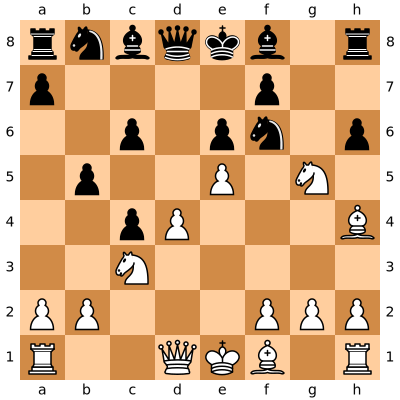

Philidor Defense: Lion Variation, Bishop Sacrifice
Stockfish Eval: -0.316
Our Eval: 0.263


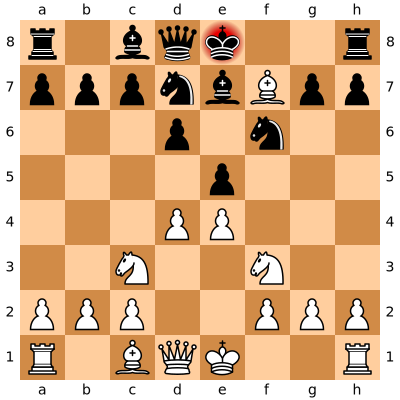

Grünfeld Defense: Exchange Variation, Sokolsky Variation
Stockfish Eval: -0.111
Our Eval: 0.449


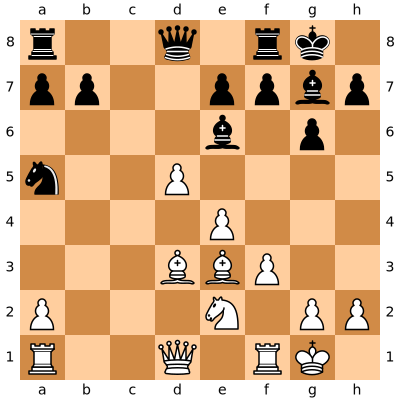

Vienna Game: Vienna Gambit, Steinitz Gambit, Zukertort Defense
Stockfish Eval: 0.06
Our Eval: -0.492


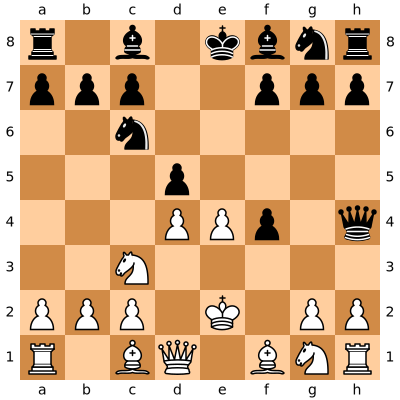

Slav Defense: Czech Variation, Carlsbad Variation, Morozevich Variation
Stockfish Eval: 0.119
Our Eval: 0.659


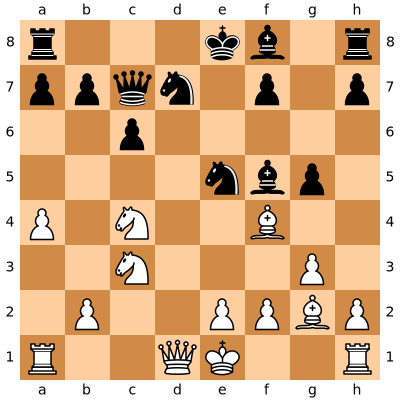

Italian Game: Deutz Gambit
Stockfish Eval: -0.227
Our Eval: 0.294


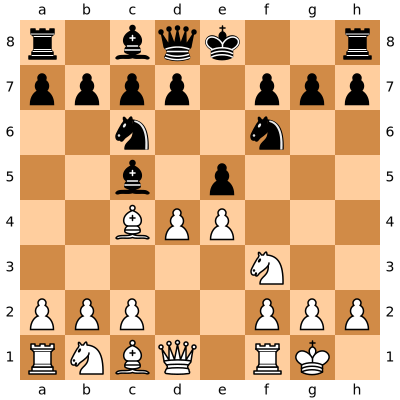

King's Gambit Accepted: Bishop's Gambit, Paulsen Attack
Stockfish Eval: -0.155
Our Eval: 0.357


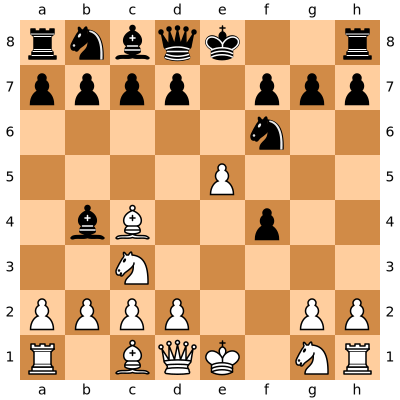

Philidor Defense: Philidor Countergambit, Berger Variation
Stockfish Eval: -0.006
Our Eval: 0.492


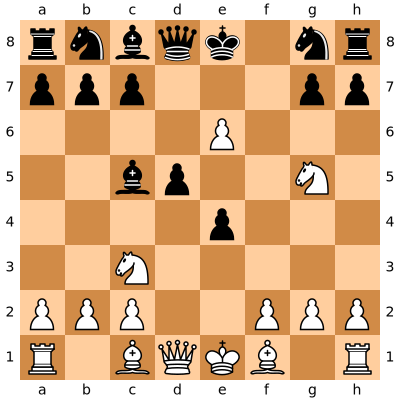

King's Pawn Game: La Bourdonnais Gambit
Stockfish Eval: 0.181
Our Eval: 0.678


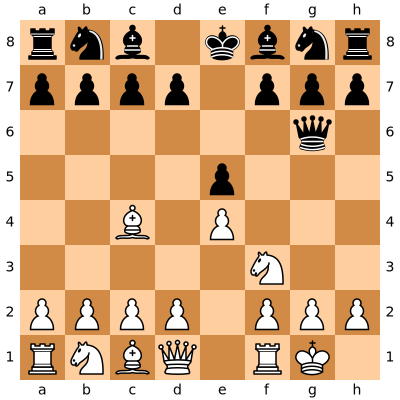

Ruy Lopez: Open Variations, Schlechter Defense
Stockfish Eval: -0.024
Our Eval: 0.471


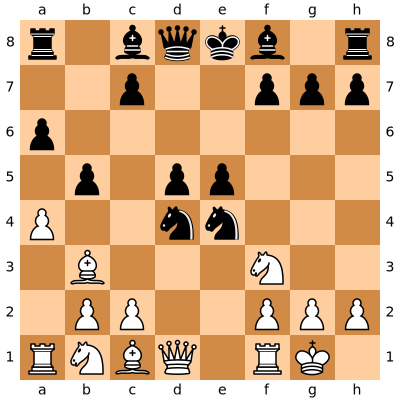

Italian Game: Evans Gambit, Ulvestad Variation
Stockfish Eval: -0.178
Our Eval: 0.316


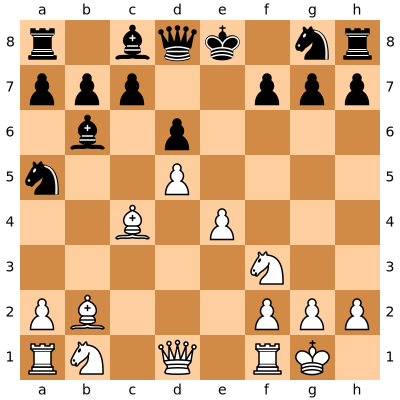

King's Gambit Accepted: Bishop's Gambit, Fraser Variation
Stockfish Eval: -0.119
Our Eval: 0.372


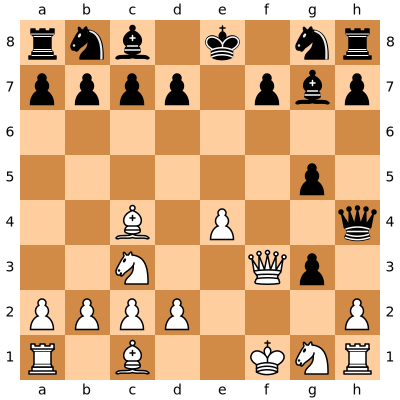

In [21]:
from IPython.display import display

import pandas as pd
pd.set_option('display.max_colwidth', -1)

df = pd.read_pickle('/Users/tom/Projects/Portfolio/data/chess-deep-learning/openings.p')

df = df[['eco', 'name', 'fen', 'moves_san', 'ab_eval', 'mcts_eval']].rename(columns={
    'eco': 'Eco',
    'name': 'Name',
    'moves_san': 'Moves',
    'ab_eval': 'Stockfish Eval',
    'mcts_eval': 'Our Eval',
})

n=20
display(df.head(n))

for _, row in df.head(n).iterrows():
    board = chess.Board(row['fen'] + ' - 0 1')
    print(row['Name'])
    print('Stockfish Eval: {}'.format(round(row['Stockfish Eval'], 3)))
    print('Our Eval: {}'.format(round(row['Our Eval'], 3)))
    display(board)

# SECTION SPLIT

## Next Steps
Training towards predicting human behavior (as we've done here) is a difficult problem, as all players are of different skills with different styles. To make this model as useful as possible, networks could be trained on a specific players' games, and then these networks could be used to train against those players, and to find prepared variations for matches. 